## This notebook is used to analyse collision warning results

In [19]:
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
font = {'family' : 'Arial',
        'size'   : 9}
plt.rc('font', **font)
plt.rcParams['mathtext.fontset'] = 'stix' #dejavuserif
sys.path.append('../../')
from Demonstration.demonstration_utils import *

def to_grayscale(fig):
    fig.canvas.draw()
    img = np.array(fig.canvas.renderer.buffer_rgba())
    grayscale_img = np.dot(img[..., :3], [0.2989, 0.5870, 0.1140])
    fig_gray, ax_gray = plt.subplots(figsize=(fig.get_size_inches()), dpi=fig.dpi)
    ax_gray.imshow(grayscale_img, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
    ax_gray.axis('off')  # Turn off the axis
    ax_gray.set_title('Grayscale plot')

path_matched_100Car = '../../../Process_100Car/MatchedEvents/'  # Path to processed data outside the repository
path_processed = '../../Data/ProcessedData/100Car/'
path_input = '../../Data/InputData/'
path_output = '../../Data/OutputData/'
fig_path = r'C:/SURFdrive/PhD progress/PhDResearch/4_Conflict/AMAR/Figures/'

### Originally matched events

In [2]:
meta_crashes = pd.read_csv(path_matched_100Car+'HundredCar_metadata_Crashes.csv')
meta_crashes.groupby('target').size()

target
following vehicle    6
lead vehicle         5
dtype: int64

In [3]:
meta_nearcrashes = pd.read_csv(path_matched_100Car+'HundredCar_metadata_NearCrashes.csv')
meta_nearcrashes.groupby('target').size().sort_values(ascending=False)

target
lead vehicle                                                 119
following vehicle                                             30
vehicle in adjacent lane                                      13
vehicle turning across another path (opposite direction)       4
vehicle moving across another path (through intersection)      2
oncoming traffic                                               1
dtype: int64

### Selected events

In [20]:
events = pd.read_hdf(path_input + '100Car/HundredCar_Crashes.h5', key='data')
meta = pd.read_csv(path_input + '100Car/HundredCar_metadata_Crashes.csv').set_index('webfileid')
print('Crash targets: ', meta.groupby('target').size())

Crash targets:  target
following vehicle    3
dtype: int64


In [21]:
events = pd.read_hdf(path_input + '100Car/HundredCar_NearCrashes.h5', key='data')
meta = pd.read_csv(path_input + '100Car/HundredCar_metadata_NearCrashes.csv').set_index('webfileid')
print('Crash targets: ', meta.groupby('target').size().sort_values(ascending=False))
print('Near-crash with veh in adjacent lane: ', meta[meta['target']=='vehicle in adjacent lane'].index.values)

Crash targets:  target
lead vehicle                44
following vehicle           15
vehicle in adjacent lane     2
dtype: int64
Near-crash with veh in adjacent lane:  [8489 8622]


### Warning evaluation

In [22]:
ttc_warning, statistics_ttc, optimal_ttc = read_data('TTC', path_output)
drac_warning, statistics_drac, optimal_drac = read_data('DRAC', path_output)
psd_warning, statistics_psd, optimal_psd = read_data('PSD', path_output)
unified_warning, statistics_unified, optimal_unified = read_data('Unified', path_output)

TTC optimal threshold: 4.0 tpr: 91.8 fpr: 0.0
DRAC optimal threshold: 0.45 tpr: 91.8 fpr: 6.56
PSD optimal threshold: 0.64 tpr: 65.57 fpr: 37.7
Unified optimal threshold: 13.0 tpr: 96.72 fpr: 8.2


In [23]:
ttc_selected = read_selected('TTC', path_output)
drac_selected = read_selected('DRAC', path_output)
psd_selected = read_selected('PSD', path_output)
unified_selected = read_selected('Unified', path_output)

PSD true warning events: 40 median period: 50.61 median timeliness: 1.3
DRAC true warning events: 56 median period: 52.8 median timeliness: 2.35
TTC true warning events: 56 median period: 52.93 median timeliness: 2.15
Unified true warning events: 59 median period: 48.15 median timeliness: 1.3


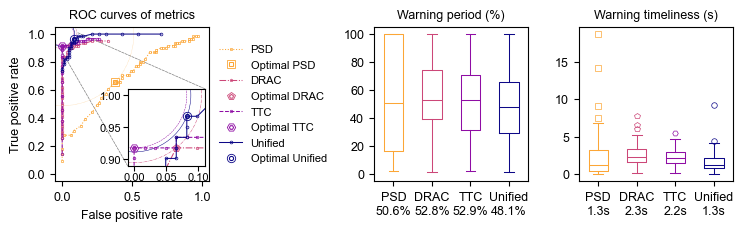

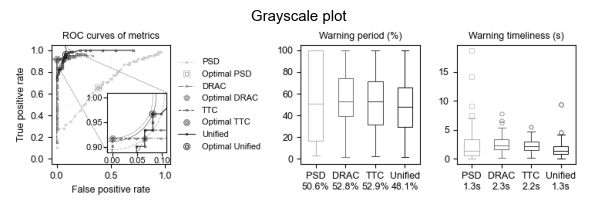

In [15]:
fig = plot_warning([statistics_ttc, optimal_ttc, ttc_selected],
                   [statistics_drac, optimal_drac, drac_selected],
                   [statistics_psd, optimal_psd, psd_selected],
                   [statistics_unified, optimal_unified, unified_selected])
to_grayscale(fig)

In [16]:
fig.savefig(fig_path + 'warning_evaluation.pdf', bbox_inches='tight', dpi=600)

In [17]:
statistics_unified[(statistics_unified['true positive rate']>0.9)&(statistics_unified['false positive rate']<0.05)]

,threshold,true warning,false warning,warning period,true positive rate,false positive rate,combined rate
75,25,55,3,0.368591,0.901639,0.04918,0.012094
76,24,55,3,0.381070,0.901639,0.04918,0.012094


### Summary of results

In [24]:
for unified, tof_unified in zip([optimal_unified['true warning'], ~optimal_unified['true warning']], ['unified true', 'unified false']):
    for ttc, tof_ttc in zip([optimal_ttc['true warning'], ~optimal_ttc['true warning']], ['ttc true', 'ttc false']):
        for drac, tof_drac in zip([optimal_drac['true warning'], ~optimal_drac['true warning']], ['drac true', 'drac false']):
            statistics = optimal_ttc[ttc&drac&unified]
            print(tof_unified, ',', tof_ttc, ',', tof_drac, ',', len(statistics), ',', statistics.index.values)

unified true , ttc true , drac true , 53 , [8296 8356 8364 8382 8388 8395 8402 8410 8435 8457 8460 8474 8478 8482
 8489 8492 8498 8513 8522 8547 8561 8565 8571 8579 8604 8618 8638 8655
 8662 8679 8708 8740 8761 8773 8797 8853 8855 8880 8900 8911 8912 8916
 8939 8944 9018 9031 9044 9051 9061 9087 9093 9109 9114]
unified true , ttc true , drac false , 2 , [8622 9101]
unified true , ttc false , drac true , 1 , [8702]
unified true , ttc false , drac false , 3 , [8463 8810 8854]
unified false , ttc true , drac true , 1 , [8793]
unified false , ttc true , drac false , 0 , []
unified false , ttc false , drac true , 1 , [8332]
unified false , ttc false , drac false , 0 , []


In [27]:
print('unified false warning:', optimal_unified[optimal_unified['false warning']].index.values)

unified false warning: [8395 8460 8463 8565 9044]
